### Imports

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

In [30]:
cust_basket = pd.read_csv('data/customer_basket.csv')
cust_info = pd.read_csv('data/customer_info.csv', index_col=0)

In [16]:
'''display(cust_basket)
display(cust_basket.info())
display(cust_basket.describe())'''

'display(cust_basket)\ndisplay(cust_basket.info())\ndisplay(cust_basket.describe())'

In [17]:
'''display(cust_info)
display(cust_info.info())
display(cust_info.describe())'''

'display(cust_info)\ndisplay(cust_info.info())\ndisplay(cust_info.describe())'

In [18]:
'cust_info.describe(include=object)'

'cust_info.describe(include=object)'

### Visualizations

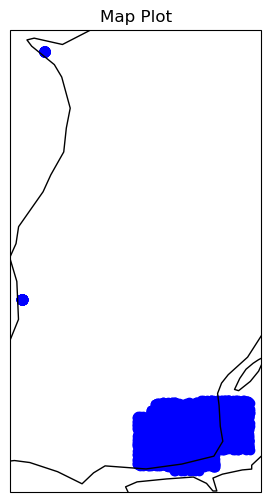

In [19]:
import cartopy.crs as ccrs

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a Cartopy map with PlateCarree projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines
ax.coastlines()

# Scatter plot of latitude and longitude
ax.scatter(cust_info['longitude'], cust_info['latitude'], color='blue', marker='o', transform=ccrs.PlateCarree())

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map Plot')

plt.show()

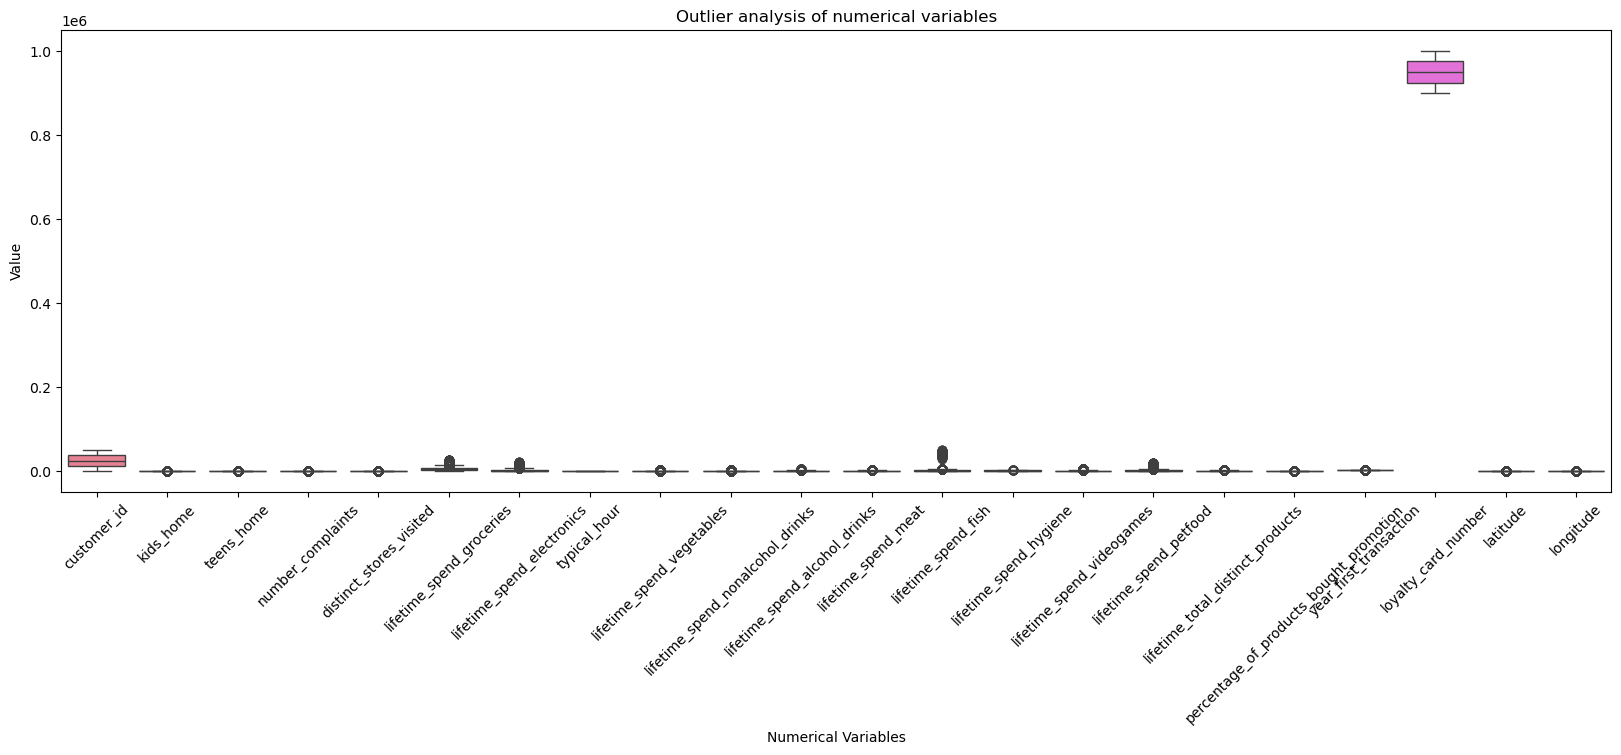

In [20]:
# Checking for outliers
plt.figure(figsize=(20,6))
sns.boxplot(data=cust_info)
plt.xticks(rotation=45)
plt.xlabel('Numerical Variables')
plt.ylabel('Value')
plt.title('Outlier analysis of numerical variables')
plt.show()

KeyError: 'customer_age'

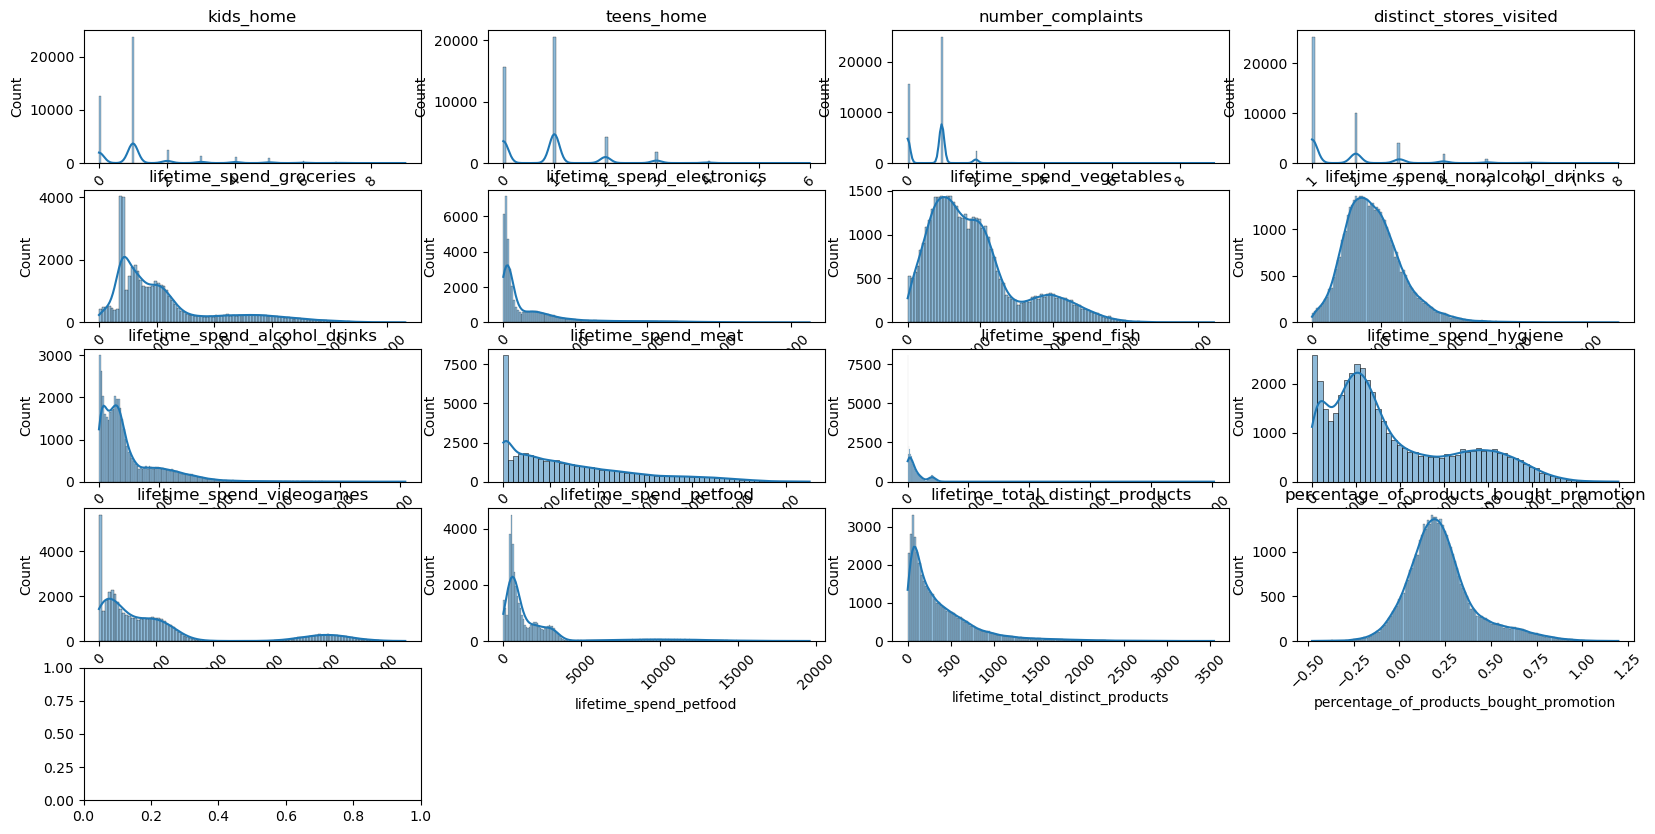

In [31]:
# Plotting
plt.figure(figsize=(20, 10))  # Increase figure size

# Define the number of rows and columns for subplots
num_rows = 5
num_cols = 4

# Loop through each column in the DataFrame and create subplots
for i, column in enumerate(['kids_home', 'teens_home', 'number_complaints',
                            'distinct_stores_visited', 'lifetime_spend_groceries',
                            'lifetime_spend_electronics', 'lifetime_spend_vegetables',
                            'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks',
                            'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene',
                            'lifetime_spend_videogames', 'lifetime_spend_petfood',
                            'lifetime_total_distinct_products', 'percentage_of_products_bought_promotion',
                            'customer_age', 'education', 'loyalty_card']):
    plt.subplot(num_rows, num_cols, i+1)
    sns.histplot(cust_info[column], kde=True)  # Histogram with Kernel Density Estimate
    plt.title(column)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()  # Adjust layout automatically
plt.show()

We notice outliers that can be explored in the variables "lifetime_spend_videogames" (gamers), "lifetime_spend_petfood" (kennels), "lifetime_spend_fish" (fishermen), "lifetime_spend_hygiene" (skincare)

## Cust_Basket

In [ ]:
'cust_basket.info()'

## Preprocessing

### Missing values

In [6]:
def nulls_to_bool(df:pd.DataFrame, col_names:list) -> pd.DataFrame:
    '''
    Function that creates a new column for each column mentioned
    With the null values replaced with 0 and the non-null with 1
    Inputs: df (dataframe)
            col_names (list of strings) - columns to treat
    Output: df (dataframe) - altered dataframe
    '''

    for col in col_names:
        df[col + '_bool'] = df[col].notnull()

    return df

In [22]:
def knn_imputing(df:pd.DataFrame) -> pd.DataFrame:
    df_numeric = df.select_dtypes(include='number')
    indices = df_numeric.index
    
    # Fit and transform the imputer on the dataset
    # We use distance because the dataset has outliers
    imputer = KNNImputer(weights='distance', n_neighbors=20).fit(df_numeric)
    df_numeric_imputed = pd.DataFrame(imputer.transform(df_numeric), columns=df_numeric.columns, index=indices)

    # Add together the non-numerical original columns and the newly imputed ones
    df_imputed = pd.concat([df.drop(columns=df_numeric.columns), df_numeric_imputed], axis=1)

    return df_imputed

In [ ]:
knn_imputing(cust_info)

c:\Users\msard\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\msard\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


<class 'pandas.core.frame.DataFrame'>
Index: 43631 entries, 0 to 43630
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customer_name                            43631 non-null  object 
 1   customer_gender                          43631 non-null  object 
 2   customer_birthdate                       43631 non-null  object 
 3   customer_id                              43631 non-null  float64
 4   kids_home                                43631 non-null  float64
 5   teens_home                               43631 non-null  float64
 6   number_complaints                        43631 non-null  float64
 7   distinct_stores_visited                  43631 non-null  float64
 8   lifetime_spend_groceries                 43631 non-null  float64
 9   lifetime_spend_electronics               43631 non-null  float64
 10  typical_hour                             43631 non-

### Datatypes

In [9]:
def float64_columns(df:pd.DataFrame) -> list:
    '''
    Function to return a list of column names with datatype 'float64' in a dataframe
    Inputs: df (dataframe)
    Output: float64_cols (list of strings) - column names with datatype 'float64'
    '''
    float64_cols = df.select_dtypes(include=['float64']).columns.tolist()
    return float64_cols

In [10]:
def float_converter(df:pd.DataFrame, variable_list:list) -> pd.DataFrame:
    '''
    Function to convert float columns in a DataFrame to more memory-efficient float types
    Inputs: df (dataframe)
            variable_list (list of strings) - names of specific columns in the DataFrame
    Output: DataFrame with columns converted to more memory-efficient float data types
    '''
    for var in variable_list:
        # Finds the minimum and maximum values in the column
        min_val = df[var].min(skipna=True)
        max_val = df[var].max(skipna=True)

        # Determine the appropriate float type based on the range of values
        float16_max = np.finfo('float16').max
        float32_max = np.finfo('float32').max
        
        if min_val > -float16_max and max_val < float16_max:
            df[var] = df[var].astype('float16')
        elif min_val > -float32_max and max_val < float32_max:
            df[var] = df[var].astype('float32')

    return df

In [11]:
def gender_coder(df:pd.DataFrame, gender_col:str) -> pd.DataFrame:
    '''
    Function that takes a gender column and changes "male" to 0 and "female" to 1
    Input:  df (dataframe)
            gender_col (string) - name of the gender column
    Output: df (dataframe) - altered dataframe
    '''
    df[gender_col] = np.where(df[gender_col] == "male", 0, 1)
    df = df.astype({gender_col : "bool"})
    return df

In [12]:
def datetime_converter(df: pd.DataFrame, datetime_cols: list) -> pd.DataFrame:
    '''
    Function that changes the dtype of the listed columns to datetime
    Input:  df (dataframe)
            datetime_cols (list of strings) - name of the datetime columns
    Output: df (dataframe) - altered dataframe
    '''
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

In [24]:
def preproc_applier(df:pd.DataFrame, datetime_cols:list=None, gender_col:str=None) -> pd.DataFrame:
    '''
    Function that applies preprocessing functions to a dataframe
    Input:  df (dataframe)
            datetime_cols (list of strings) - column names to change to datetime
            gender_col (string) - name of the gender column
    Output: df (dataframe) - altered dataframe
    '''
    if datetime_cols is not None:
        df = datetime_converter(df, datetime_cols)

    float64_cols = float64_columns(df)
    df = float_converter(df, float64_cols)

    if gender_col is not None:
        df = gender_coder(df, gender_col)
    
    return df

In [32]:
cust_info_treated = preproc_applier(cust_info, ['customer_birthdate'], 'customer_gender')

C:\Users\msard\AppData\Local\Temp\ipykernel_18380\1578020299.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


In [33]:
cust_info_treated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43631 entries, 0 to 43630
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   customer_id                              43631 non-null  int64         
 1   customer_name                            43631 non-null  object        
 2   customer_gender                          43631 non-null  bool          
 3   customer_birthdate                       43631 non-null  datetime64[ns]
 4   kids_home                                43107 non-null  float16       
 5   teens_home                               42610 non-null  float16       
 6   number_complaints                        42977 non-null  float16       
 7   distinct_stores_visited                  42322 non-null  float16       
 8   lifetime_spend_groceries                 43631 non-null  float16       
 9   lifetime_spend_electronics               436

### Normalization / Standerdization

In [34]:
# Apply robust scaler
numeric_cust_info = cust_info_treated.drop(['customer_name'], axis=1)

# Initialize the RobustScaler
scaler = RobustScaler()
scaler.fit(numeric_cust_info)
scaled_data = scaler.transform(numeric_cust_info)


c:\Users\msard\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float16DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.ObjectDType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float32DType'>, <class 'numpy.dtypes.Float16DType'>, <class 'numpy.dtypes.Float16DType'>)

In [ ]:
# Addressing skewness ( log transformation)

### Feature Engineering

In [35]:
cust_info_treated['vegetarian'] = np.where((cust_info_treated['lifetime_spend_meat'] == 0) & 
                                           (cust_info_treated['lifetime_spend_fish'] == 0), 
                                           1, 0)

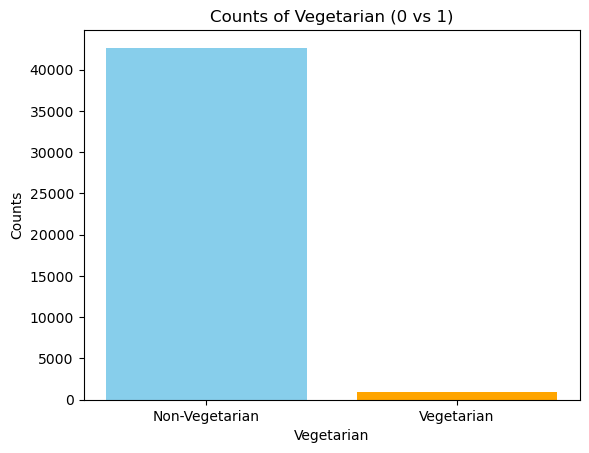

In [36]:
# Count the occurrences of each value in the 'vegetarian' column
vegetarian_counts = cust_info_treated['vegetarian'].value_counts()

# Plot the counts
plt.bar(vegetarian_counts.index, vegetarian_counts.values, color=['skyblue', 'orange'])

# Add labels and title
plt.xlabel('Vegetarian')
plt.ylabel('Counts')
plt.title('Counts of Vegetarian (0 vs 1)')
plt.xticks(vegetarian_counts.index, ['Non-Vegetarian', 'Vegetarian'])

# Show plot
plt.show()

In [45]:
cust_info[cust_info['customer_name'].str.contains('\.')]['customer_name']

array(['Bsc. Anna Yeary', 'Phd. Robert Massey', 'Bsc. Joe Syrett', ...,
       'Bsc. Rita Malone', 'Msc. Mary Ross', 'Bsc. Milton Friend'],
      dtype=object)

In [50]:
cust_info['customer_name'].str.extract(r'(\b[A-Z][a-z]+[.]?)')

,0
0,David
1,Belinda
2,Evelyn
3,Ora
4,Lonnie
...,...
43626,Amelia
43627,Silvia
43628,Addie
43629,Msc.


In [52]:
def extract_education(name):
    if 'Bsc.' in name:
        return 1
    elif 'Msc.' in name:
        return 2
    elif 'Phd.' in name:
        return 3
    else:
        return 0

# Apply the function to create a new 'Education' column
cust_info_treated['education'] = cust_info_treated['customer_name'].apply(extract_education)

# Extract the first name and last name
cust_info_treated['name'] = cust_info_treated['customer_name'].str.replace('Msc.|Bsc.|Phd.', '').str.strip()

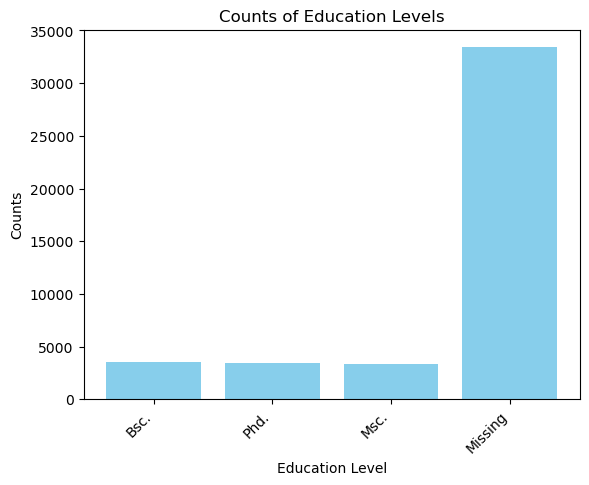

In [53]:
# Count the occurrences of each value in the 'Education' column
education_counts = cust_info_treated['education'].value_counts()

# Count the missing values in the 'Education' column
missing_values_count = cust_info_treated['education'].isnull().sum()

# Add the count of missing values as a new entry in the 'education_counts' Series
education_counts['Missing'] = missing_values_count

# Plot the counts
plt.bar(education_counts.index, education_counts.values, color='skyblue')

# Add labels and title
plt.xlabel('Education Level')
plt.ylabel('Counts')
plt.title('Counts of Education Levels')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

# Show plot
plt.show()

### Feature Selection

In [ ]:
def variable_correlation(df: pd.DataFrame, threshold: float = 0.7) -> list:
    # Generates the correlation matrix
    correlation_matrix = df.drop(['customer_name','typical_hour','year_first_transaction','customer_gender', 'customer_birthdate'], axis=1).corr()
    
    # Creates a heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

    # Finds highly correlated variables (below -0.7 or above 0.7, not including)
    correlated_vars = list()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname_i = correlation_matrix.columns[i]
                colname_j = correlation_matrix.columns[j]
                correlated_vars.append(colname_i)
                correlated_vars.append(colname_j)
                correlated_vars.append(' / ')

    print('Highly correlated variables: ', correlated_vars)

In [ ]:
variable_correlation(cust_info)

Highly correlated variables:
- 'lifetime_spend_meat', 'lifetime_spend_electronics'
- 'lifetime_spend_hygiene', 'lifetime_spend_meat'
- 'lifetime_spend_videogames', 'lifetime_spend_electronics'
- 'lifetime_spend_videogames', 'lifetime_spend_meat'
- 'latitude', 'lifetime_spend_fish'

So we should remove 'lifetime_spend_meat' and 'lifetime_spend_videogames'

In [ ]:
# Reducing dimensionality
# - Principal Component Analysis
# - t-distributed Stochastic Neighbor Embedding (t-SNE)